In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.bayestar import BayestarWebQuery
import numpy as np
import os
from bokeh.plotting import *
output_notebook()
%load_ext autoreload
%autoreload 2
from getGaiaData import GaiaClusterMembers
from astropy.modeling.models import KingProjectedAnalytic1D
from astropy.modeling import models, fitting
import scipy.optimize
import scipy.stats as stats
from dustmaps.config import config
config.reset()

Loading BokehJS ...

In [2]:
clusterName ='NGC_2682' #Define cluster here, named as in the 'OCcompiled_clean_v2.csv' file
pwd = clusterName+'_dir' #Pathway for directory where output to be stored

Radius= 0.3316290446725802
Reading data from file NGC_2682_dir/NGC_2682_GaiaData.ecsv ... 
Finding radial-velocity members ... 


Finding parallax members ... 
finding proper-motion members ...
combining memberships ...


/Users/annachilds/opt/anaconda3/envs/BASE9/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/annachilds/opt/anaconda3/envs/BASE9/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Reading data from file NGC_2682_dir/NGC_2682_GaiaData.ecsv ... 
Radius= 1.658107419758892
Finding radial-velocity members ... 
Finding parallax members ... 
finding proper-motion members ...
combining memberships ...


plotting CMD ...
generating phot file ...
Length of members =  1441
generating yaml file ...
Final r_core= 0.049006633817374974
Saving data to file NGC_2682_dir/NGC_2682.csv ... 
done.


<Figure size 720x720 with 0 Axes>

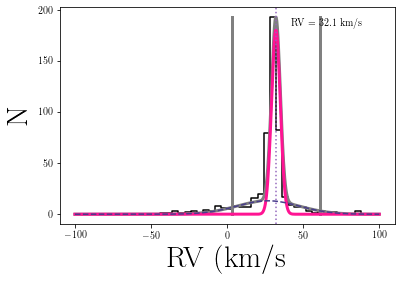

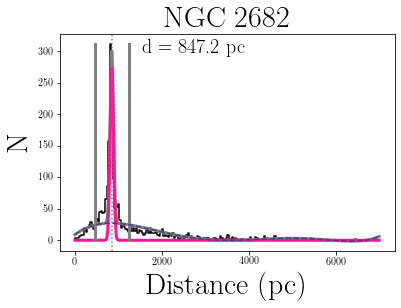

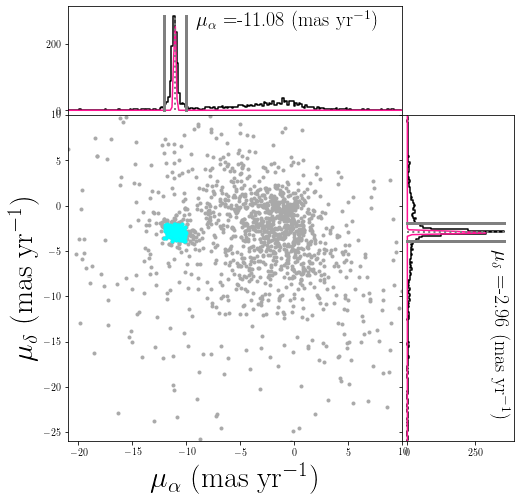

<Figure size 720x720 with 0 Axes>

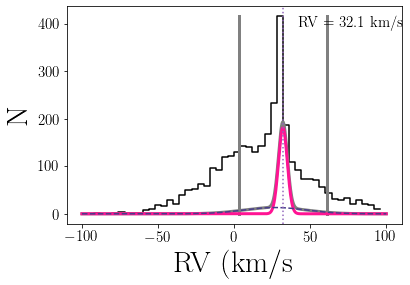

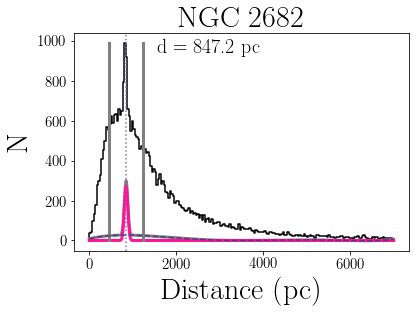

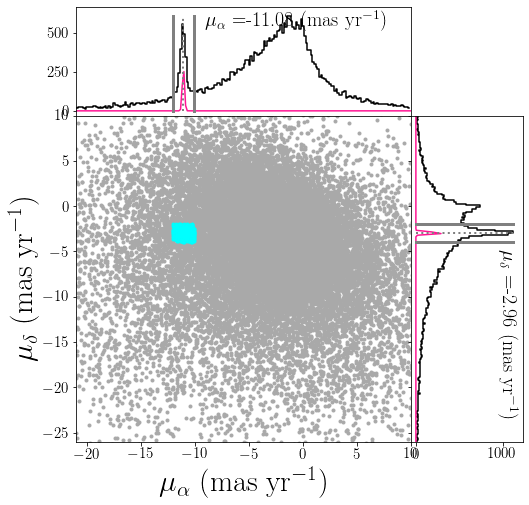

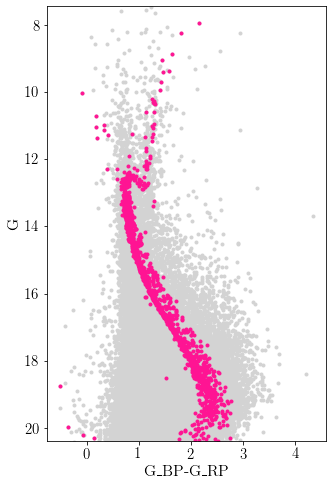

In [3]:
OCdf = pd.read_csv('OCcompiled_clean_v2.csv') #file with prior values for cluster centers from previous literature
row = OCdf.loc[OCdf['ID'] == clusterName].iloc[0]
dmod = 5.*np.log10(row['dist[pc]']) - 5.
err_dmod = (5.*1./np.log(10.)*(1./row['dist[pc]']))*row['err_dist[pc]'] # error propagation
cluster = GaiaClusterMembers()
cluster.verbose = 1
try:
    os.makedirs(pwd+'/plots')
    os.makedirs(pwd)
except:
    next
    
cluster.plotNameRoot = pwd+'/plots/'
cluster.photOutputFileName = pwd +'/'+clusterName + '.phot'
cluster.saveDataFile = pwd +'/'+clusterName + '.csv'
cluster.yamlOutputFileName = pwd + '/base9.yaml'
cluster.yamlTemplateFileName = 'template_base9.yaml'
cluster.yamlInputDict = {
    'photFile' : clusterName + '.phot',
    'outputFileBase' : pwd,
    'modelDirectory' : '/projects/p31721/BASE9/base-models/',
    'msRgbModel' : 5,
    'Fe_H' : [row['[Fe/H]'], row['[Fe/H]'], np.max([row['err_[Fe/H]'], 0.3])],
    'Av' : [row['Av[mag]'], row['Av[mag]'], np.max([row['err_Av[mag]'], 0.3])],
    'Y' : [0.29, 0.29, 0.0], # keep the defaults
    'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
    'logAge' : [np.log10(row['age[Myr]']*10**6), np.log10(row['age[Myr]']*10**6), np.inf],
    'distMod' : [dmod, dmod, np.max([err_dmod, 1.0])],
}

cluster.sig_fac = 10 #default is to include stars within 10 sigma bounds around cluster fit mean.
cluster.deredden = 1 #Set to 1 to apply reddening corrections.
#cluster.runAll(clusterName) #run this line to download Gaia data that will be saved to the file clusterName+'_dir/'+clusterName+'_GaiaData.ecsv'
cluster.runAll(clusterName,filename=clusterName+'_dir/'+clusterName+'_GaiaData.ecsv') #run this line if Gaia data has already been downloaded


In [4]:
#Here is a list of the filters you can input for the mag, color1, and color2 arguments below

#Gaia filters: 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
#Pan-Starss filters:'g_mean_psf_mag','r_mean_psf_mag','i_mean_psf_mag','z_mean_psf_mag','y_mean_psf_mag', 
#2MASS filters: 'j_m', 'h_m', 'ks_m',


In [5]:
#interactive isochrone tool, may need to download additional dependencies to run

layout = cluster.createInteractiveIsochrone('PARSEC.model', 
                                            initialGuess = [
                                                cluster.yamlInputDict['logAge'][0], 
                                                cluster.yamlInputDict['Fe_H'][0],
                                                cluster.yamlInputDict['distMod'][0],
                                                cluster.yamlInputDict['Av'][0]
                                            ],
                                   mag ='phot_g_mean_mag', color1 ='phot_bp_mean_mag', color2 ='phot_rp_mean_mag', xrng = [-4,4], yrng = [24,5])
# in order to run a Python callback in a Jupyter notbook, you need to include the following
def bkapp(doc):
    doc.add_root(layout)
    
show(bkapp)